# Estimator Benchmarks

Notebook for benchmarking known IV estimators against different data generating processes.

Current roster:
- Split-sample IV **TODO**
- 2SLS
- Jackknife IV **TODO**
- LIML 
- Mostly harmless ML **TODO**
- DeepIV **TODO**
- DoubleML **TODO**

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.iv import IV2SLS

In [2]:
# import pre-condition: run `pip install -e .` in the root directory
from src.data.lin_norm_generator import LinearNormalDataGenerator
from src.viz.plotting import kde_ridgeplot

df = LinearNormalDataGenerator().generate()

# TabPFN-style data generating process

In [3]:
import torch
from torch import nn
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

In [4]:
MAX_VARS = 100

class GaussianNoise(nn.Module):
    """
    Lifted from https://github.com/automl/TabPFN/blob/main/tabpfn/priors/mlp.py
    TODO introduce shared covariance matrix
    """
    def __init__(self, std, device):
        super().__init__()
        self.std = std
        self.device=device

    def forward(self, x):
        return x + torch.normal(torch.zeros_like(x), self.std)


def causes_sampler_f(num_causes):
    means = np.random.normal(0, 1, (num_causes))
    std = np.abs(np.random.normal(0, 1, (num_causes)) * means)
    return means, std

class IVGenerator(nn.Module):
    """
    Neural network to generate IV datasets.

    TODO add ability to generate IV controls to cover the Angrist/Frandsen case
    """
    def __init__(self, 
                tau: float,
                max_vars: int,
                n_instruments: int,
                instrument_covariance: torch.Tensor,
                instrument_strength: float, # this currently translates to mu^2/n_samples
                tau_activation: str = 'identity',
                instrument_activation: str = 'identity',
                # TODO add controls as well
                control_activation: str = 'identity',
                control_covariance: torch.Tensor = None, 
                control_str: float = 0,
                n_controls: int = 0,

                ):
        super().__init__()
        self.max_vars = max_vars
        # TODO are these actually needed?
        #self.controls = nn.Linear(max_vars, 1)
        self.instruments = nn.Linear(max_vars, 1)

        #Nself.n_controls = n_controls
        self.n_instruments = n_instruments

        if control_covariance is not None:
            assert control_covariance.shape == (n_controls, n_controls)

        assert instrument_covariance.shape == (n_instruments, n_instruments)
        self.instrument_covariance = instrument_covariance
        self.instrument_sampler = MultivariateNormal(torch.zeros(self.n_instruments), self.instrument_covariance)
        
        # currently follows the Beta pattern of Lennon et al. 2022, corresponds to their pi
        self.instrument_coefficients = torch.pow(torch.ones(self.n_instruments) * 0.7, 
                                         torch.arange(0, self.n_instruments))

        # shuffle coefficients
        self.instrument_coefficients = self.instrument_coefficients[torch.randperm(self.n_instruments)]
        # determine C coefficient
        C = torch.sqrt(instrument_strength / (torch.t(self.instrument_coefficients) @ self.instrument_covariance @ self.instrument_coefficients))

        # TODO debug this, should be 1
        self.sigma_v = torch.abs(C*torch.t(self.instrument_coefficients) @ self.instrument_covariance @ self.instrument_coefficients)
        self.sigma_v = torch.sqrt(self.sigma_v)
        self.sigma_y = 1

        self.instrument_coefficients = C * self.instrument_coefficients

        
        # TODO need to ensure that confounder covariance is positive definite
        self.confound_covariance = torch.Tensor([[self.sigma_y**2, self.sigma_y*self.sigma_v], 
                                                 [self.sigma_y*self.sigma_v, self.sigma_v**2]])
        print(self.confound_covariance)
        self.confound_sampler = MultivariateNormal(torch.zeros(2), self.confound_covariance)

        self.tau = tau
        self.control_str = control_str

        self.activations = {
            'identity': lambda x: x,
            'relu': F.relu,
            'sigmoid': F.sigmoid,
            'tanh': F.tanh,
            'softplus': F.softplus,
            'leaky_relu': F.leaky_relu,
            'elu': F.elu,
        }
    
        self.tau_activation = self.activations[tau_activation]
        self.instrument_activation = self.activations[instrument_activation]
        #self.confounder_activation = self.activations[confounder_activation]


    def forward(self):
        """Generates a single data sample"""
        #confound_sample = torch.cat([torch.randn(self.n_confounds), torch.zeros(MAX_VARS - self.n_confounds)])

        # noise sample [\epislon_y, \epeilson_v] according to confounder covariance
        #noise_sample = torch.normal(TODO)
        instrument_sample = torch.cat([self.instrument_sampler.sample(), torch.zeros(self.max_vars - self.n_instruments)])

        epislon_y, epsilon_v = self.confound_sampler.sample()
        #confounds = self.confounder_activation(self.confounders(confound_sample))
        pi = torch.cat([self.instrument_coefficients, torch.zeros(self.max_vars - self.n_instruments)])
        treat = self.instrument_activation(torch.t(pi) @ instrument_sample) + epsilon_v
        
        #print(treat.shape)

        outcome = self.tau*self.tau_activation(treat) + torch.randn(1) + epislon_y

        # return data matrix of T, Y, Z
        return torch.cat([torch.Tensor([treat, outcome]), instrument_sample])

        # return data matrix of T, Y, X, Z
        #return torch.cat([treat, outcome, confound_sample, instrument_sample])
        
    def batch(self, batch_size: int):
        """Generate batch of examples"""
        return torch.stack([self.forward() for _ in range(batch_size)])


In [5]:
def generate_cov_matrix(n_vars, base=0.5):
    """Generates the covariance matrix for the instruments per Lennon et al. 2022"""
    cov = np.zeros((n_vars, n_vars))
    for i in range(n_vars):
        for j in range(n_vars):
            cov[i, j] = base**(np.abs(i-j))
    return cov

In [6]:
n_samples = 1000
mu2 = 200
n_instruments = 100
iv_gen = IVGenerator(
            tau=1,
            max_vars=n_instruments,
            n_instruments=n_instruments,
            instrument_covariance=torch.Tensor(generate_cov_matrix(n_instruments)), 
            instrument_strength=mu2/n_samples,
        )

data = iv_gen.batch(n_samples).detach().numpy()

tensor([[1.0000, 0.8019],
        [0.8019, 0.6431]])


In [7]:
data.shape

(1000, 102)

# Lennon et al. 2022 Replication

In [8]:
data[:, :-2].shape

(1000, 100)

<Axes: >

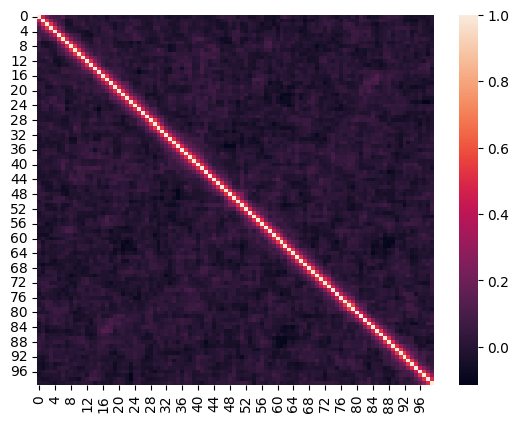

In [9]:
sns.heatmap(np.corrcoef(data[:, 2:].T))

## Run simulations for Lennon et al. 2022 replication

In [10]:
from linearmodels.iv.model import IV2SLS, _OLS, IVLIML
from tqdm import tqdm

In [64]:
n_trials = 500


result_dict = {
    'tsls': [],
    'ols': [],
    'liml': [],
}

for _ in tqdm(range(n_trials)):
    data = iv_gen.batch(n_samples).detach().numpy()

    df = pd.DataFrame(data[:, 2:], columns=[f'z{i}' for i in range(n_instruments)])
    df['t'] = data[:, 0]
    df['y'] = data[:, 1]
    
    # TSLS
    iv = IV2SLS(dependent=df.y, 
                exog=None,
                endog=df.t, 
                instruments=df.iloc[:, :-2])
    result_dict['tsls'].append(iv.fit().params['t'])

    # OLS
    ols = _OLS(dependent=df.y, exog=df.t)
    result_dict['ols'].append(ols.fit().params['t'])

    # LIML
    liml = IVLIML(dependent=df.y,
                  exog=None,
                  endog=df.t, 
                  instruments=df.iloc[:, :-2])
    result_dict['liml'].append(liml.fit().params['t'])

    # Mostly Harmless ML



result_df = pd.DataFrame(result_dict)

100%|██████████| 500/500 [03:08<00:00,  2.65it/s]


In [65]:
result_df.describe()

,tsls,ols,liml
count,500.000000,500.000000,500.000000
mean,1.299137,1.950371,0.993781
std,0.080520,0.039898,0.115354
min,0.992550,1.840834,0.533424
25%,1.247951,1.924532,0.929089
50%,1.305625,1.952086,1.005906
75%,1.355372,1.976603,1.068744
max,1.498663,2.064987,1.258778


In [66]:
result_df.head()

,tsls,ols,liml
0,1.381688,1.962351,1.138188
1,1.197963,1.889304,0.889212
2,1.282397,1.953157,0.911482
3,1.341553,1.945282,1.017853
4,1.254226,1.947100,0.908321


In [67]:
# ridge plots require dataframes in long format
result_df_long = result_df.melt(var_name='method', value_name='estimate')
result_df_long.head()
result_df_long = result_df_long.sort_values('method', ascending=False)

/home/tliu/.conda/envs/liv-test/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/tliu/.conda/envs/liv-test/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/tliu/.conda/envs/liv-test/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/tliu/.conda/envs/liv-test/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_

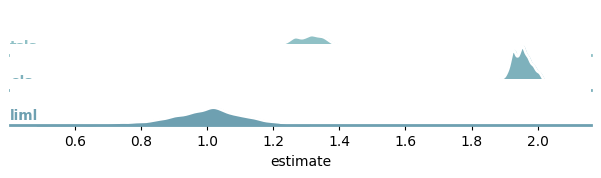

In [73]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
kde_ridgeplot(result_df_long, 'method', 'estimate', pal, figsize=(4, 6))
#plt.axvline(x=1, ls='--', color='black')
#plt.xlim(0, 2)